In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Linear Congruential Generator (LCG) Class
class LCG:
    def __init__(self, seed, a=1664525, c=1013904223, m=2**32):
        self.seed = seed
        self.a = a
        self.c = c
        self.m = m
        self.current = seed

    def random(self):
        """
        Generates a pseudo-random number between 0 and 1.
        Every time you call lcg.random(), the current value is updated according to the linear congruential formula: 
        X_{n+1} = (a * X_n + c) mod m
        """
        self.current = (self.a * self.current + self.c) % self.m
        return self.current / self.m  # Normalize to [0, 1)

In [7]:
# Box-Muller Transform for Normal Distribution
def box_muller(lcg):
    """Generate two independent standard normally distributed random numbers."""
    u1 = lcg.random()
    u2 = lcg.random()
    
    z1 = math.sqrt(-2.0 * math.log(u1)) * math.cos(2.0 * math.pi * u2)
    z2 = math.sqrt(-2.0 * math.log(u1)) * math.sin(2.0 * math.pi * u2)
    
    return z1, z2

# Normal Distribution
def generate_normal_demand(lcg, mu, sigma):
    """Generate a normally distributed random number with mean mu and standard deviation sigma."""
    z1, _ = box_muller(lcg)  # Use one of the two generated normal variables
    return mu + sigma * z1   # Adjust by mean and standard deviation

# Uniform Distribution
def generate_uniform_demand(lcg, a, b):
    """Generate a uniformly distributed random number between a and b."""
    u = lcg.random()
    return a + (b - a) * u  # Scale the uniform number to the range [a, b]

# Exponential Distribution
def generate_exponential_demand(lcg, lam):
    """Generate an exponentially distributed random number with rate lambda."""
    u = lcg.random()
    return -math.log(u) / lam

# Poisson Distribution
def generate_poisson_demand(lcg, lam):
    """Generate a Poisson distributed random number with mean lambda. Using Acceptance-Rejection Method."""
    L = math.exp(-lam)
    k = 0
    p = 1.0
    while p > L:
        k += 1
        u = lcg.random()
        p *= u
    return k - 1

# Binomial Distribution
def generate_binomial_demand(lcg, n, p):
    """Generate a binomially distributed random number with parameters n and p. Using Acceptance-Rejection Method."""
    successes = 0
    for _ in range(n):
        if lcg.random() < p:  # Simulate a Bernoulli trial
            successes += 1
    return successes

# Log-Normal Distribution
def generate_lognormal_demand(lcg, mu, sigma):
    """Generate a log-normally distributed random number."""
    z1, _ = box_muller(lcg)
    return math.exp(mu + sigma * z1)


In [8]:
# Function to simulate demand
def simulate_demand(lcg, mu, sigma, iterations, distribution='normal'):
    demands = []
    
    for _ in range(iterations):
        # Choose the distribution to generate demand
        if distribution == 'normal':
            demand = generate_normal_demand(lcg, mu, sigma)
        elif distribution == 'uniform':
            demand = generate_uniform_demand(lcg, mu - sigma, mu + sigma)  # Uniform around mean
        elif distribution == 'exponential':
            demand = generate_exponential_demand(lcg, 1 / mu)  # Using mean = 1 / lambda
        elif distribution == 'poisson':
            demand = generate_poisson_demand(lcg, mu)
        elif distribution == 'binomial':
            demand = generate_binomial_demand(lcg, n=100, p=mu/100)  # Example n and p
        elif distribution == 'lognormal':
            demand = generate_lognormal_demand(lcg, mu, sigma)
        else:
            raise ValueError(f"Unknown distribution: {distribution}")
        
        demands.append(demand)
    
    return np.array(demands)

# Plot demand and theoretical distribution
def plot_demand_distribution(demands, mu, sigma, distribution):
    plt.hist(demands, bins=50, density=True, alpha=0.6, color='g', label='Simulated Demand')
    
    # Plot theoretical distribution based on the selected type
    x = np.linspace(min(demands), max(demands), 1000)
    
    if distribution == 'normal':
        plt.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', lw=2, label='Normal PDF')
    elif distribution == 'uniform':
        a, b = mu - sigma, mu + sigma
        plt.plot(x, stats.uniform.pdf(x, a, b - a), 'r-', lw=2, label='Uniform PDF')
    elif distribution == 'exponential':
        plt.plot(x, stats.expon.pdf(x, scale=mu), 'r-', lw=2, label='Exponential PDF')
    elif distribution == 'poisson':
        k = np.arange(0, max(demands))
        plt.bar(k, stats.poisson.pmf(k, mu), alpha=0.75, label='Poisson PMF')
    elif distribution == 'lognormal':
        plt.plot(x, stats.lognorm.pdf(x, sigma, scale=np.exp(mu)), 'r-', lw=2, label='Lognormal PDF')
    
    plt.title(f"Demand Distribution: {distribution.capitalize()}")
    plt.xlabel('Demand')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# Simulate newsvendor problem
def simulate_newsvendor(Q, mu, sigma, iterations, distribution='normal'):
    lcg = LCG(seed=1234)  # Initialize the LCG with a seed
    profits = []
    
    for _ in range(iterations):
        # Generate demand for the selected distribution
        if distribution == 'normal':
            demand = generate_normal_demand(lcg, mu, sigma)
        elif distribution == 'uniform':
            demand = generate_uniform_demand(lcg, mu - sigma, mu + sigma)
        elif distribution == 'exponential':
            demand = generate_exponential_demand(lcg, 1 / mu)
        elif distribution == 'poisson':
            demand = generate_poisson_demand(lcg, mu)
        elif distribution == 'binomial':
            demand = generate_binomial_demand(lcg, n=100, p=mu/100)
        elif distribution == 'lognormal':
            demand = generate_lognormal_demand(lcg, mu, sigma)
        else:
            raise ValueError(f"Unknown distribution: {distribution}")
        
        # Calculate profit
        if demand <= Q:
            profit = p * demand - c * Q + v * (Q - demand)
        else:
            profit = p * Q - c * Q
        profits.append(profit)
    
    # Return the average profit
    return np.mean(profits)


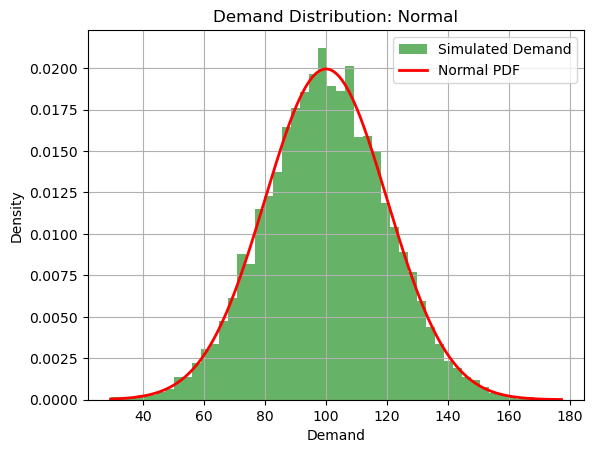

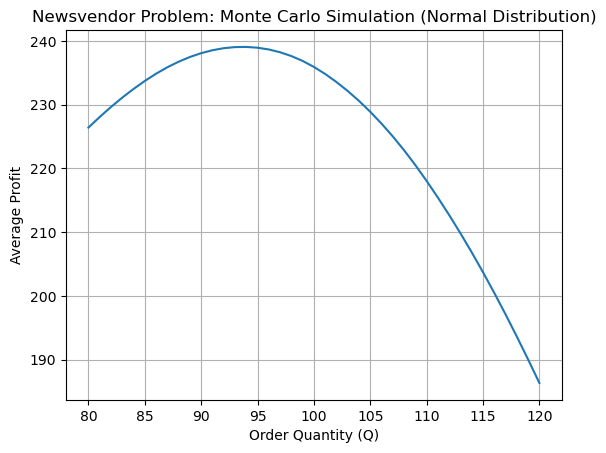

In [14]:

# Parameters for the newsvendor problem
p = 10  # Selling price per unit
c = 7   # Cost per unit
v = 2   # Salvage value per unit (if unsold)
mu = 100  # Mean demand
sigma = 20  # Standard deviation of demand
iterations = 10000  # Number of Monte Carlo simulations
distribution = 'normal'  # Choose from 'normal', 'uniform', 'exponential', 'poisson', 'binomial', 'lognormal'

# Initialize the LCG with a seed
lcg = LCG(seed=1234)

# Simulate demand for the selected distribution
demands = simulate_demand(lcg, mu, sigma, iterations, distribution)

# Plot the simulated demand along with the theoretical distribution
plot_demand_distribution(demands, mu, sigma, distribution)

# Simulate the newsvendor problem for different order quantities
order_quantities = np.arange(80, 121)
average_profits = [simulate_newsvendor(Q, mu, sigma, iterations, distribution) for Q in order_quantities]

# Plot the results of the newsvendor simulation
plt.plot(order_quantities, average_profits)
plt.xlabel('Order Quantity (Q)')
plt.ylabel('Average Profit')
plt.title(f'Newsvendor Problem: Monte Carlo Simulation ({distribution.capitalize()} Distribution)')
plt.grid(True)
plt.show()
